# Creating different Unet models in tensorflow

> different type of `unet model` from tversky focal loss paper will be implemented here

In [41]:
#| default_exp tf_model_creation

In [42]:
#| export
import tensorflow as tf
import numpy as np
import pandas as pd
from fastcore.all import *
from fastcore.test import *
from pathlib import Path
from typing import List, Tuple, Dict, Union, Callable, Optional
from tensorflow.keras import backend as K
import os

In [43]:

print(os.environ.get('CUDA_PATH'))

/usr/lib/cuda


# Start with normal unet

In [44]:
#| export
def pooling(
        inputs,
        max_pool_only=False,
        both=True,
        pool_size=2):
    if both:
        p1 = tf.keras.layers.MaxPooling2D(
            (pool_size, pool_size))(inputs)
        p2 = tf.keras.layers.AvgPool2D(
            pool_size=(pool_size, pool_size))(inputs)
        return tf.keras.layers.concatenate([p1, p2])
    elif max_pool_only:
        return tf.keras.layers.MaxPooling2D(
            (pool_size, pool_size))(inputs)
    else:
        return tf.keras.layers.AvgPool2D(
            pool_size=(pool_size, pool_size))(inputs)
            


In [45]:
# | export
def conv_block(
        inputs, 
        filter_no, 
        kernel_size, 
        batch_nm=True, 
        dropout=True, 
        drp_rt=0.1,
        kernel_initializer='glorot_normal' #option he_normal
        ):
    'Create a conv block with batch norma and dropout'
    c1 = tf.keras.layers.Conv2D(
        filter_no,
        (kernel_size, kernel_size),

        kernel_initializer='glorot_normal',
        padding='same',
        activation=None)(inputs)
    if batch_nm:
        c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    if dropout:
        c1 = tf.keras.layers.Dropout(drp_rt)(c1)
    return c1

In [46]:
input_size = tf.random.normal((1, 1152, 1632, 1))
out_ = conv_block(input_size, 32, 3, batch_nm=False, dropout=False)
test_eq([1,1152, 1632, 32], out_.shape)

In [48]:
#| export
def double_conv(
        inputs, 
        filter_no, 
        kernel_size, 
        batch_nm=True, 
        dropout=True, 
        drp_rt=0.1,
        kernel_initializer='glorot_normal' #option he_normal
        ):
    'Create double conv block with batch norma and dropout'

    c1 = tf.keras.layers.Conv2D(
        filter_no,
        (kernel_size, kernel_size),

        kernel_initializer='glorot_normal',
        padding='same',
        activation=None)(inputs)
    if batch_nm:
        c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    if dropout:
        c1 = tf.keras.layers.Dropout(drp_rt)(c1)
    c2 = tf.keras.layers.Conv2D(
        filter_no,
        (kernel_size, kernel_size),

        kernel_initializer='glorot_normal',
        padding='same',
        activation=None)(c1)
    if batch_nm:
        c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation('relu')(c2)
    if dropout:
        c2 = tf.keras.layers.Dropout(drp_rt)(c2)
    return c2

In [50]:
out_c = double_conv(inputs=input_size, filter_no=32, kernel_size=3, batch_nm=True, dropout=True, drp_rt=0.1)
out_p = pooling(out_c, both=True)


In [51]:
test_eq([1,1152, 1632, 32], out_c.shape)
test_eq([1,576, 816, 64], out_p.shape)

In [52]:

h, w, c = 1152, 1632, 1

In [53]:
#| export
def encoder_block(
        input_size:tf.Tensor,
        filter_size:List[int]=[16,32,64,128,256],
        kernel_initializer:str='glorot_normal' #option he_normal
                 ):
    'Create Encoder block for Unet'

    inputs = tf.keras.layers.Input(input_size)
    outputs = []
    p = inputs 
    

    for i in filter_size:
        c = double_conv(
            inputs=p, 
            filter_no=i, 
            kernel_size=3, 
            batch_nm=True, 
            dropout=True, 
            drp_rt=0.1,
            kernel_initializer='glorot_normal' #option he_normal
            )
        p = pooling(c, both=True)
        outputs.append(c)

    final_filter_size = filter_size[-1]*2
    final_layer = double_conv(
        inputs=p, 
        filter_no=final_filter_size, 
        kernel_size=3, 
        batch_nm=True, 
        dropout=True, 
        drp_rt=0.1,
        kernel_initializer='glorot_normal' #option he_normal
        )
    #outputs.append(final_layer)
    return inputs, outputs, final_layer

In [54]:
#h, w, c = 1052, 1632, 1
#h, w, c = 1152, 1632, 1
input_img = tf.random.normal((1, h, w, c))
inputs,enc_outputs, final_l = encoder_block(
    input_size=(h, w, c),
    filter_size=[16,32,64,128],
    kernel_initializer='glorot_normal' #option he_normal
    )

In [55]:
enc_outputs

[<KerasTensor: shape=(None, 1152, 1632, 16) dtype=float32 (created by layer 'dropout_16')>,
 <KerasTensor: shape=(None, 576, 816, 32) dtype=float32 (created by layer 'dropout_18')>,
 <KerasTensor: shape=(None, 288, 408, 64) dtype=float32 (created by layer 'dropout_20')>,
 <KerasTensor: shape=(None, 144, 204, 128) dtype=float32 (created by layer 'dropout_22')>]

In [56]:
final_l

<KerasTensor: shape=(None, 72, 102, 256) dtype=float32 (created by layer 'dropout_24')>

In [57]:
test_eq((None, 1152, 1632, 1), inputs.shape)

In [58]:
expected_shapes = [
    (None, 1152, 1632, 16),
    (None, 576, 816, 32),
    (None, 288, 408, 64),
    (None, 144, 204, 128),
]

for (expected, actual) in zip(expected_shapes, enc_outputs):
    test_eq(expected, actual.shape)

In [59]:
len(enc_outputs)

4

In [60]:
#| export
def crop_and_concat(upsampled: tf.Tensor, skip_connection: tf.Tensor) -> tf.Tensor:
    """
    Crop or pad the skip connection and concatenate it with the upsampled tensor.
    Args:
    - upsampled (tf.Tensor): Tensor from the decoder path.
    - skip_connection (tf.Tensor): Corresponding tensor from the encoder path.
    Returns:
    - tf.Tensor: Tensor after cropping or padding and concatenation.
    """
    skip_shape = skip_connection.shape[1:3]
    upsample_shape = upsampled.shape[1:3]

    # Calculate difference in shapes and determine if cropping or padding is needed
    height_diff = skip_shape[0] - upsample_shape[0]
    width_diff = skip_shape[1] - upsample_shape[1]

    if height_diff > 0 or width_diff > 0:
        print(f' Cropping branch')
        # Cropping the skip connection
        crop_height = height_diff // 2
        crop_width = width_diff // 2
        cropped_skip_connection = skip_connection[:, 
                                                  crop_height: crop_height + upsample_shape[0], 
                                                  crop_width: crop_width + upsample_shape[1], 
                                                  :]
        return tf.keras.layers.concatenate([upsampled, cropped_skip_connection], axis=-1)
    elif height_diff < 0 or width_diff < 0:

        print(f' Padding branch')
        # Padding the upsampled tensor
        pad_height = -height_diff // 2
        pad_width = -width_diff // 2
        padded_upsampled = tf.pad(upsampled, 
                                  [
                                      [0, 0], 
                                      [pad_height, pad_height], 
                                      [pad_width, pad_width], 
                                      [0, 0]
                                      ], 
                                  mode='constant', constant_values=0)
        return tf.keras.layers.concatenate([padded_upsampled, skip_connection], axis=-1)
    else:
        # Shapes match, direct concatenation
        return tf.keras.layers.concatenate([upsampled, skip_connection], axis=-1)



In [61]:

        
skip_connection = tf.random.normal([1, 16, 16, 128])  # Simulating a feature map from the encoder
upsampled = tf.random.normal([1, 14, 14, 128])
crop_concat_image = crop_and_concat(upsampled, skip_connection)
test_eq(crop_concat_image.shape, [1, 14, 14, 256])


 Cropping branch


In [77]:
#| export
def decoder_block(
    filter_list:List[int],
    encoder_outputs:List[tf.Tensor],
    bottleneck:tf.Tensor,
   ):
    'Create a decoder block for unet'

    filter_list = filter_list[::-1]
    encoder_outputs = encoder_outputs[::-1]


    decoder_output_list = []
    x = bottleneck


    for i, filter_no in enumerate(filter_list):

        #upsample
        x = tf.keras.layers.Conv2DTranspose(
                                            filter_no,
                                            (2,2),
                                            strides=(2,2),
                                            padding='same',
                                            )(x)
        encoder_output = encoder_outputs[i]
        #print(f'encoder_output.shape: {encoder_output.shape}')
        
        # Handle the shape mismatch (if any)
        ################################################################################
        x = crop_and_concat(x, encoder_output)
        ################################################################################



        # Concatenate the upsampled feature map with the corresponding encoder feature map
        decoder_output_list.append(x)

        x = double_conv(
            inputs=x, 
            filter_no=filter_no, 
            kernel_size=3, 
            batch_nm=True, 
            dropout=True, 
            drp_rt=0.1,
            kernel_initializer='glorot_normal' #option he_normal
            )
    return x, decoder_output_list


    



In [63]:
inputs,enc_outputs, final_l = encoder_block(
    input_size=(h, w, c),
    filter_size=[16,32,64,128],
    kernel_initializer='glorot_normal' #option he_normal
    )
out_, dec_out_list = decoder_block(
    filter_list=[16,32,64,128],
    encoder_outputs=enc_outputs,
    bottleneck=final_l,
    )

In [64]:
expected_decoder_shapes = [
    (None, 144, 204, 256),
    (None, 288, 408, 128),
    (None, 576, 816, 64),
    (None, 1152, 1632, 32),
]

for (expected, actual) in zip(expected_decoder_shapes, dec_out_list):
    test_eq(expected, actual.shape)
test_eq((None, 1152, 1632, 16), out_.shape)

In [65]:
#| export
def unet_model(
    input_size:Tuple[int]=(1152, 1632, 1),
    filter_list:List[int]=[16,32,64,128],
    kernel_initializer:str='glorot_normal', #option he_normal
    n_classes:int=1
    ):
    'Create a unet model'
    inputs,enc_outputs, final_l = encoder_block(
        input_size=input_size,
        filter_size=filter_list,
        kernel_initializer=kernel_initializer
        )
    final_output, decoder_outputs = decoder_block(
        filter_list=filter_list,
        encoder_outputs=enc_outputs,
        bottleneck=final_l
        )
    if n_classes <=1:   
        final_output = tf.keras.layers.Conv2D(
            n_classes,(1, 1), activation='sigmoid')(final_output)
    else:   
        final_output = tf.keras.layers.Conv2D(
            n_classes,(1, 1), activation='softmax')(final_output)
    return tf.keras.models.Model(inputs=inputs, outputs=final_output)


In [66]:
model_ = unet_model(
    input_size=(1152, 1632, 1),
    filter_list=[16,32,64,128],
    n_classes=1,
    )

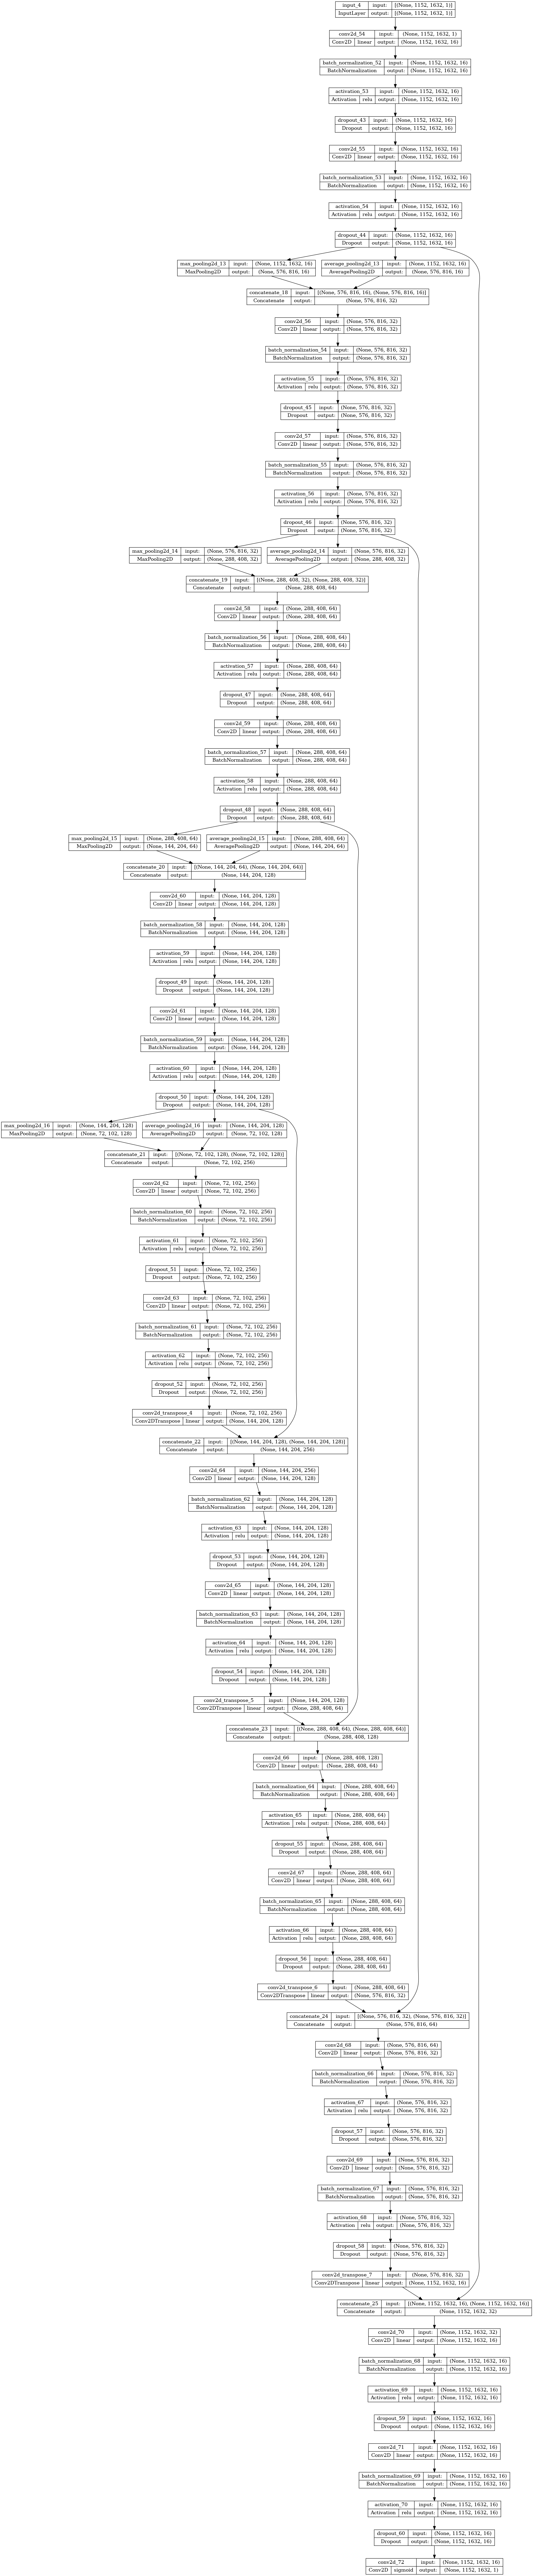

In [67]:
tf.keras.utils.plot_model(model_, show_shapes=True, show_layer_activations=True)

# Attention Unet

In [78]:
#| export
def unet_gating_signal(
                     input:tf.Tensor,
                     out_size:int,
                     is_batchnorm:bool,
                    name:str,
                    kinit:str='glorot_normal',
                    ):
    ' this is simply 1x1 convolution, bn, activation '

    shape = K.int_shape(input)
    x = tf.keras.layers.Conv2D(
        out_size, (1, 1), strides=(1, 1), padding="same",  
        kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = tf.keras.layers.BatchNormalization(name=name + '_bn')(x)
    x = tf.keras.layers.Activation('relu', name = name + '_act')(x)
    return x

In [79]:
#| export
def expend_as(tensor, rep,name):
	my_repeat = tf.keras.layers.Lambda(lambda x, repnum: K.repeat_elements(
		                                                 x, 
														 repnum, 
														 axis=3), 
														 arguments={'repnum': rep},  
														 name='psi_up'+name)(tensor)
	return my_repeat

In [80]:
#| export
def attention_blocks(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same feature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    # getting x to the same shape as gating signal g
    theta_x = tf.keras.layers.Conv2D(
                                     inter_shape, 
                                     (2, 2), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     name='xl'+name)(x)

    shape_theta_x = K.int_shape(theta_x)

    # getting the gating signal to the same number of feature channels as inter_shape
    phi_g = tf.keras.layers.Conv2D(
                                   inter_shape,
                                   (1, 1),
                                   padding='same')(g)

    upsample_g = tf.keras.layers.Conv2DTranspose(
                                          inter_shape,
                                          (3, 3),
                                          strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                          padding='same', 
                                          name='g_up'+name)(phi_g)

    concat_xg = tf.keras.layers.add([upsample_g, theta_x])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)

    psi = tf.keras.layers.Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)

    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = tf.keras.layers.UpSampling2D(
                                         size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)


    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)

    y = tf.keras.layers.multiply([upsample_psi, x], name='q_attn'+name)

    result = tf.keras.layers.Conv2D(
                                   shape_x[3], 
                                   (1, 1),
                                    padding='same',
                                    name='q_attn_conv'+name)(y)
    result_bn = tf.keras.layers.BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

In [85]:
#| export
def decoder_block_attention_gates(
    filter_list:List[int],
    encoder_outputs:List[tf.Tensor],
    bottleneck:tf.Tensor,
   ):
    'Create a decoder block for unet with attention gates'

    filter_list = filter_list[::-1]
    encoder_outputs = encoder_outputs[::-1]


    decoder_output_list = []
    x = bottleneck


    for i, filter_no in enumerate(filter_list):

        encoder_output = encoder_outputs[i]

        gating_signal_output = unet_gating_signal(
            x, 
            filter_no,
            is_batchnorm=True, 
            name='gating_signal'+str(i))


        attention_blocks_output = attention_blocks(
            encoder_output,  # like conv_16
            gating_signal_output, # like gate16 
            inter_shape=filter_no, 
            name='attention_block'+str(i))

        #upsample
        x = tf.keras.layers.UpSampling2D(size=(2, 2), data_format='channels_last',name=f'upsampling_{i}')(x)

        # adding attention block to upsample image
        x = tf.keras.layers.concatenate([x, attention_blocks_output], axis=-1)
        
        x = double_conv(
            inputs=x, 
            filter_no=filter_no, 
            kernel_size=3, 
            batch_nm=True, 
            dropout=True, 
            drp_rt=0.1,
            kernel_initializer='glorot_normal' #option he_normal
            )
        decoder_output_list.append(x)
    return x, decoder_output_list


    



In [81]:
inputs, encoder_output, bottle_neck_enc = encoder_block(
    input_size=(256, 256,1),
    filter_size=[64,128,256,512],
    )
dec_final, decoder_outputs = decoder_block_attention_gates(
    filter_list=[64,128,256,512],
    encoder_outputs=encoder_output,
    bottleneck=bottle_neck_enc,
    )

testing decoder output shape

In [82]:
expected_attn_deocder_shapes = [
    (None, 32, 32, 512),
    (None, 64, 64, 256),
    (None, 128, 128, 128),
    (None, 256, 256, 64),
]
for (expected, actual) in zip(expected_attn_deocder_shapes, decoder_outputs):
    test_eq(expected, actual.shape)

In [83]:
#| export
def unet_model_attention_gates(
    input_size:Tuple[int]=(256, 256, 1),
    filter_list:List[int]=[64,128,256,512],
    kernel_initializer:str='glorot_normal', #option he_normal
    n_classes:int=1
    ):
    'Create a unet model'
    inputs,enc_outputs, final_l = encoder_block(
        input_size=input_size,
        filter_size=filter_list,
        kernel_initializer=kernel_initializer
        )
    final_output, decoder_outputs = decoder_block_attention_gates(
        filter_list=filter_list,
        encoder_outputs=enc_outputs,
        bottleneck=final_l
        )
    if n_classes <=1:   
        final_output = tf.keras.layers.Conv2D(
            n_classes,(1, 1), activation='sigmoid')(final_output)
    else:   
        final_output = tf.keras.layers.Conv2D(
            n_classes,(1, 1), activation='softmax')(final_output)
    return tf.keras.models.Model(inputs=inputs, outputs=final_output)

In [84]:
attn_unet_model_ =unet_model_attention_gates(
    input_size=(256, 256, 1),
    filter_list=[64,128,256,512],
    n_classes=1,
    )

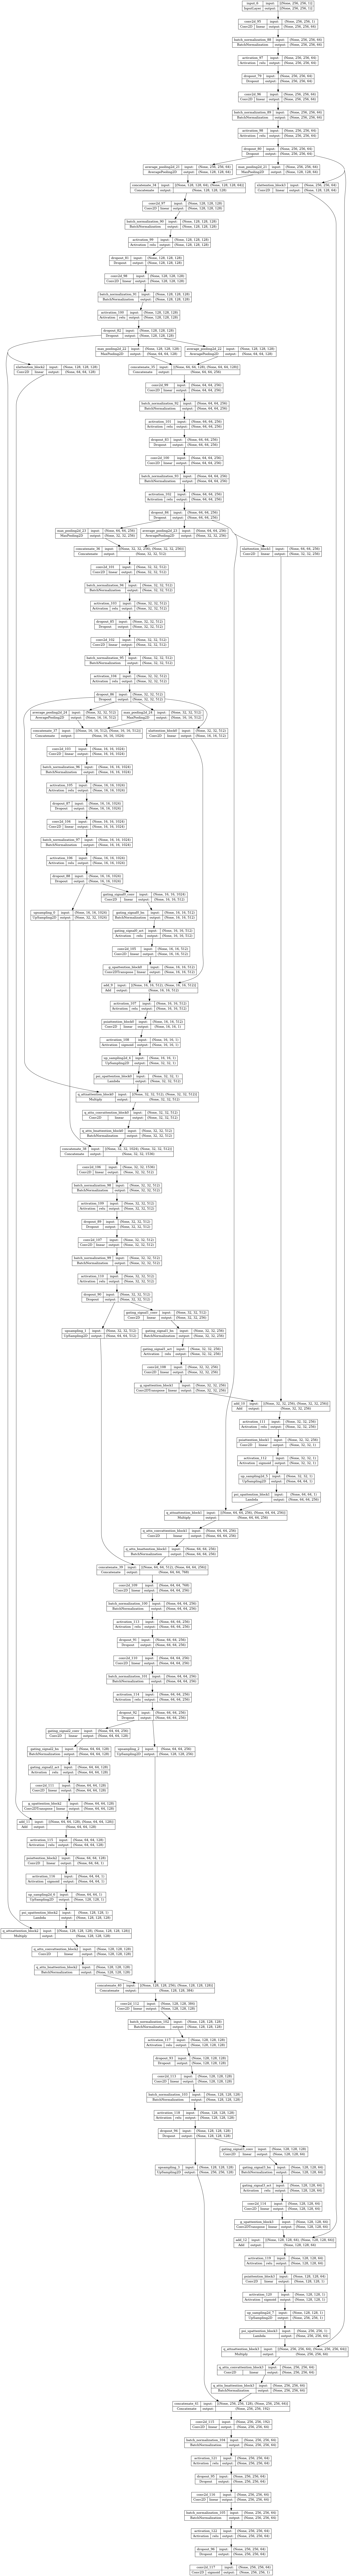

In [75]:
tf.keras.utils.plot_model(attn_unet_model_, show_shapes=True, show_layer_activations=True)

# Residual Attention Unet

In [86]:
#| export
def res_double_conv(
        inputs, 
        filter_no, 
        kernel_size, 
        batch_nm=True, 
        dropout=True, 
        drp_rt=0.1,
        kernel_initializer='glorot_normal' #option he_normal
        ):
    'Create double conv block with batch norma and dropout'

    # first conv block(conv->bn->relu->dropout)
    c1 = tf.keras.layers.Conv2D(
        filter_no,
        (kernel_size, kernel_size),

        kernel_initializer='glorot_normal',
        padding='same',
        activation=None)(inputs)
    if batch_nm:
        c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    if dropout:
        c1 = tf.keras.layers.Dropout(drp_rt)(c1)

    # second conv block(conv->bn->relu->dropout)
    c2 = tf.keras.layers.Conv2D(
        filter_no,
        (kernel_size, kernel_size),

        kernel_initializer='glorot_normal',
        padding='same',
        activation=None)(c1)
    if batch_nm:
        c2 = tf.keras.layers.BatchNormalization()(c2)

    if dropout:
        c2 = tf.keras.layers.Dropout(drp_rt)(c2)

    shortcut = tf.keras.layers.Conv2D(
        filter_no,
        (1, 1),
        kernel_initializer=kernel_initializer,
        padding='same',
        activation=None
        )(inputs)

    if batch_nm:
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    res_path = tf.keras.layers.add([shortcut, c2])
    res_path = tf.keras.layers.Activation('relu')(res_path)
    return res_path

In [87]:
#| export
def residual_encoder_block(
        input_size:tf.Tensor,
        filter_size:List[int]=[16,32,64,128,256],
        kernel_initializer:str='glorot_normal' #option he_normal
                 ):
    'Create Encoder block for residual Unet'

    inputs = tf.keras.layers.Input(input_size)
    outputs = []
    p = inputs 
    

    for i in filter_size:
        c = res_double_conv(
            inputs=p, 
            filter_no=i, 
            kernel_size=3, 
            batch_nm=True, 
            dropout=True, 
            drp_rt=0.1,
            kernel_initializer='glorot_normal' #option he_normal
            )
        p = pooling(c, both=True)
        outputs.append(c)

    final_filter_size = filter_size[-1]*2
    final_layer = res_double_conv(
        inputs=p, 
        filter_no=final_filter_size, 
        kernel_size=3, 
        batch_nm=True, 
        dropout=True, 
        drp_rt=0.1,
        kernel_initializer='glorot_normal' #option he_normal
        )
    #outputs.append(final_layer)
    return inputs, outputs, final_layer

In [88]:
#| export
def residual_decoder_block(
    filter_list:List[int],
    encoder_outputs:List[tf.Tensor],
    bottleneck:tf.Tensor,
   ):
    'Create a decoder block for unet with attention gates'

    filter_list = filter_list[::-1]
    encoder_outputs = encoder_outputs[::-1]


    decoder_output_list = []
    x = bottleneck


    for i, filter_no in enumerate(filter_list):

        encoder_output = encoder_outputs[i]

        gating_signal_output = unet_gating_signal(
            x, 
            filter_no,
            is_batchnorm=True, 
            name='gating_signal'+str(i))


        attention_blocks_output = attention_blocks(
            encoder_output,  # like conv_16
            gating_signal_output, # like gate16 
            inter_shape=filter_no, 
            name='attention_block'+str(i))

        #upsample
        x = tf.keras.layers.UpSampling2D(size=(2, 2), data_format='channels_last',name=f'upsampling_{i}')(x)

        # adding attention block to upsample image
        x = tf.keras.layers.concatenate([x, attention_blocks_output], axis=-1)
        
        x = res_double_conv(
            inputs=x, 
            filter_no=filter_no, 
            kernel_size=3, 
            batch_nm=True, 
            dropout=True, 
            drp_rt=0.1,
            kernel_initializer='glorot_normal' #option he_normal
            )
        decoder_output_list.append(x)
    return x, decoder_output_list


    



In [89]:
#| export
def residual_attn_unet(
    input_size:Tuple[int]=(256, 256, 1),
    filter_list:List[int]=[64,128,256,512],
    kernel_initializer:str='glorot_normal', #option he_normal
    n_classes:int=1
    ):
    ' Create a residual attention unet model'
    inputs, enc_outputs, bottleneck = residual_encoder_block(
        input_size=input_size,
        filter_size=filter_list,
        kernel_initializer=kernel_initializer
        )
    final_output, decoder_outputs = residual_decoder_block(
        filter_list=filter_list,
        encoder_outputs=enc_outputs,
        bottleneck=bottleneck
        )
    if n_classes <=1:   
        final_output = tf.keras.layers.Conv2D(
            n_classes,(1, 1), activation='sigmoid')(final_output)
    else:
        final_output = tf.keras.layers.Conv2D(
            n_classes,(1, 1), activation='softmax')(final_output)

    return tf.keras.models.Model(inputs=inputs, outputs=final_output)



In [90]:
resdual_attn_unet = residual_attn_unet(
    input_size=(256, 256, 1),
    filter_list=[64,128,256,512],
    n_classes=1,
    )

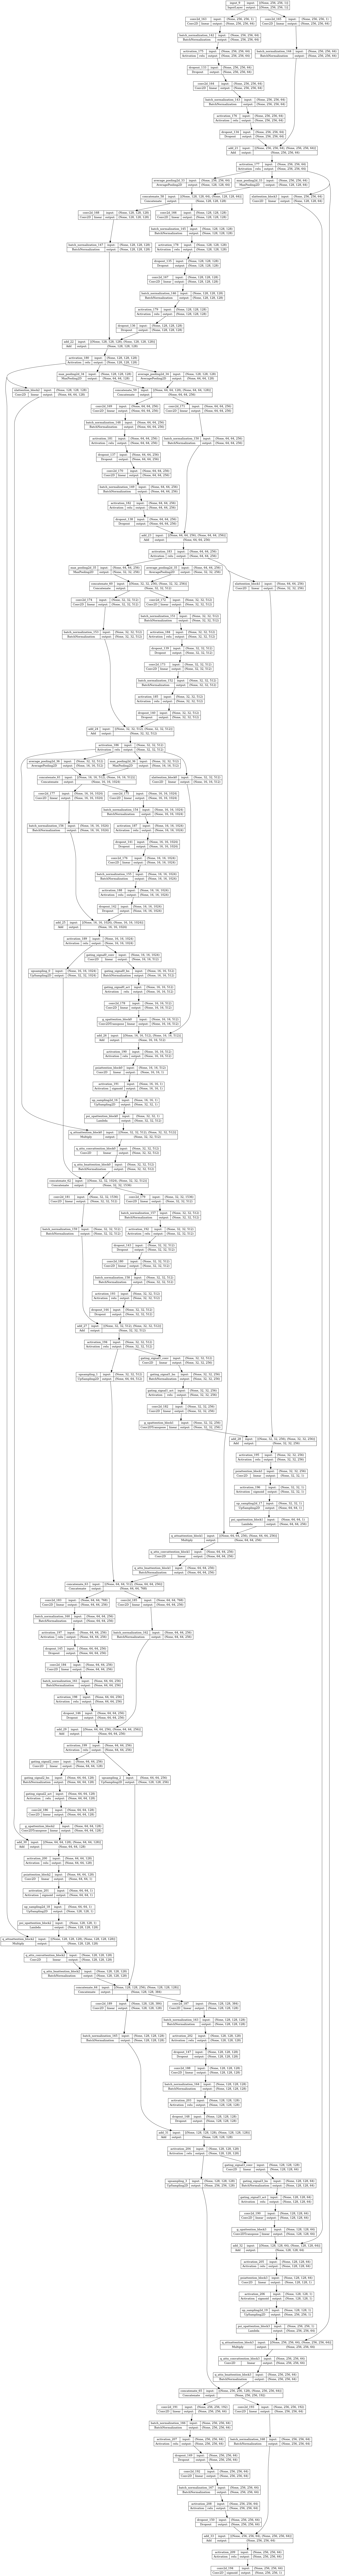

In [91]:
tf.keras.utils.plot_model(resdual_attn_unet, show_shapes=True, show_layer_activations=True)

# Checking purpose

In [93]:
from tensorflow.keras import layers

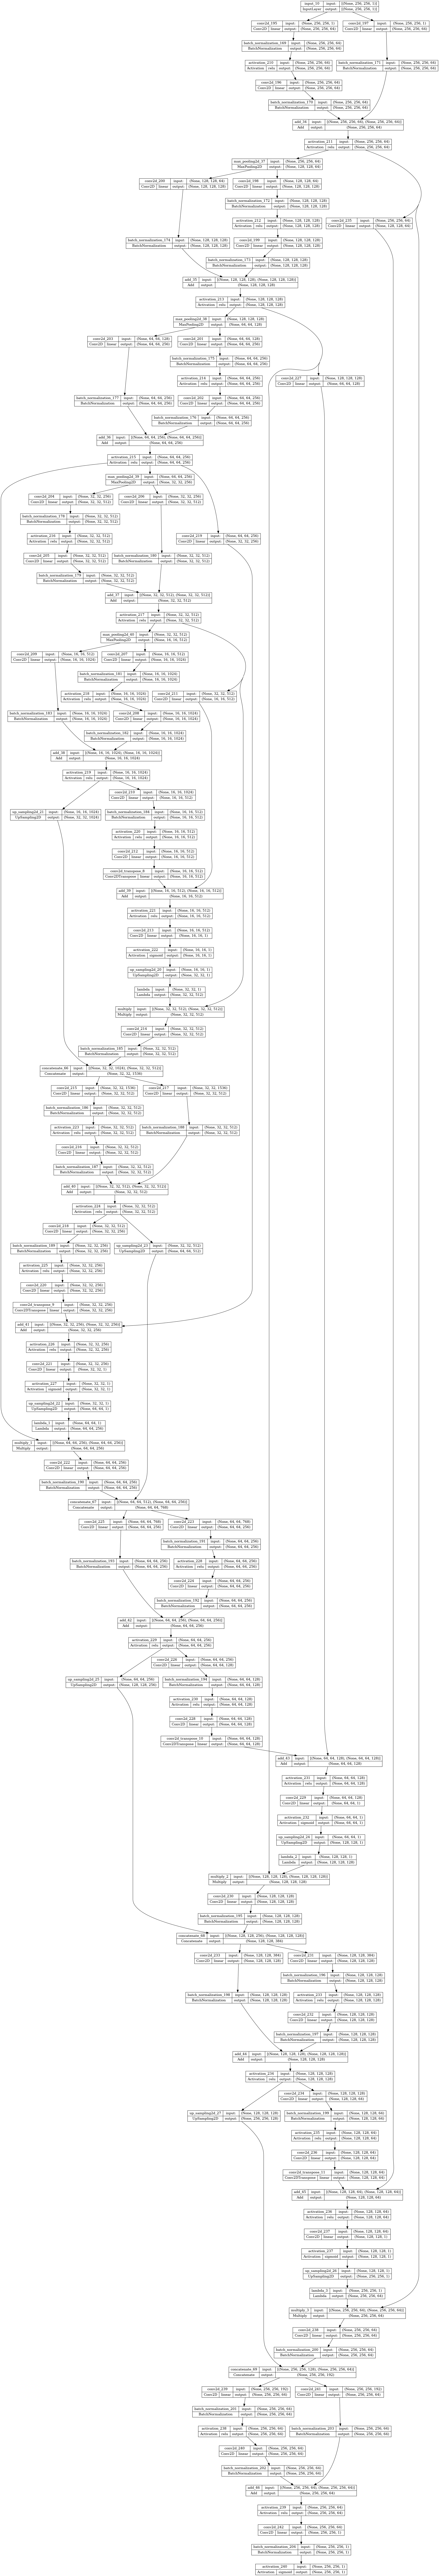

In [97]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path


def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = tf.keras.models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

input_shape = (256, 256, 1)
attn_res_unet_ = Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)
tf.keras.utils.plot_model(attn_res_unet_, show_shapes=True, show_layer_activations=True)

In [163]:
#| hide
import nbdev; nbdev.nbdev_export()